# Testing Ising model

In [2]:
import numpy as np
# import matplotlib.pyplot as plt
from pyscf import fci

## Building XXX Heisenberg model

In [50]:
def generate_inds(value, p, q, r, s):
    """
    Generate all the indices for the 4 different terms in the 2-body hamiltonian
    """
    res = []
    res.append((value, p, q, r, s))
    res.append((value, r, s, p, q))
    # res.append((-value, p, s, r, q))
    # res.append((-value, r, q, p, s))

    res.append((value, p, q, s, r))
    res.append((value, q, p, r, s))
    res.append((value, q, p, s, r))

    # permutation symmetries
    res.append((value, s, r, p, q))
    res.append((value, r, s, q, p))
    res.append((value, s, r, q, p))


    return res

for n_sites in range(2, 8, 2):

    J_xy = 1
    J_z = 1
    h = np.zeros((2*n_sites, 2*n_sites))
    v = np.zeros((2*n_sites, 2*n_sites, 2*n_sites, 2*n_sites))

    for i in range(n_sites):
        j = i+1
        if j == n_sites:
            j = 0

        h[i, i] += -J_z/4
        h[j, j] += -J_z/4 
        h[i+n_sites, i+n_sites] += -J_z/4
        h[j+n_sites, j+n_sites] += -J_z/4

    # populating 2body terms
        
    for i in range(n_sites):
        j = i+1
        if j == n_sites:
            j = 0

        values = generate_inds(J_z/4, j, j, i, i)
        for value, p, q, r, s in values:
            v[p, q, r, s] += value
        

        values = generate_inds(J_z/4, j, j, i+n_sites, i+n_sites)
        for value, p, q, r, s in values:
            v[p, q, r, s] += value
    
        values = generate_inds(J_z/4, j+n_sites, j+n_sites, i, i)
        for value, p, q, r, s in values:
            v[p, q, r, s] += value

        values = generate_inds(J_z/4, j+n_sites, j+n_sites, i+n_sites, i+n_sites)
        for value, p, q, r, s in values:
            v[p, q, r, s] += value

        values = generate_inds(J_xy/2, j, i, j+n_sites, i+n_sites)
        for value, p, q, r, s in values:
            v[p, q, r, s] += value

        values = generate_inds(J_xy/2, i, j, i+n_sites, j+n_sites)
        for value, p, q, r, s in values:
            v[p, q, r, s] += value


    e_0 = J_z/4*n_sites

    # solve fullci problem
    e, fcivec = fci.direct_spin0.kernel(1*h, 1*v, 2*n_sites, 2*n_sites, nroots=1,
                                        max_memory=10000)
    e_exact = 0.25-np.log(2)
    print(f"FCI energy for {n_sites}: ", (e+e_0)/(2*n_sites), "; error: ", (e+e_0)/(2*n_sites)-e_exact)

FCI energy for 2:  -1.2782119259115534 ; error:  -0.8350647453516081
FCI energy for 4:  -0.5629897290600718 ; error:  -0.11984254850012654
FCI energy for 6:  -0.546112176636998 ; error:  -0.10296499607705267


In [13]:
import numpy as np
from scipy.linalg import eigh

# Define Pauli spin matrices
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])

# Define function for Kronecker product with identity
def kron_id(matrix, N, L):
  """
  Creates Kronecker product of matrix with identity matrices.

  Args:
      matrix: The matrix for Kronecker product.
      N: Number of identity matrices before the matrix.
      L: Number of sites.

  Returns:
      A Kronecker product of the matrix with identity matrices.
  """
  result = matrix
  for _ in range(N):
    result = np.kron(I, result)

  for _ in range(L-N-1):
    result = np.kron(result, I)
  return 1/2*result

# Define function to create spin operators on Nth site
def spin_operator(operator, N, L):
  """
  Creates a spin operator (Sx, Sy, Sz) on the Nth site.

  Args:
      operator: The Pauli spin matrix (sigma_x, sigma_y, sigma_z).
      N: The site index for the spin operator.
      L: Total number of sites.

  Returns:
      A Kronecker product representing the spin operator on Nth site.
  """
  return kron_id(operator, N, L)

# Define system size (number of sites)
L = 6 # Change this for different system size

# Create spin operators on each site
Sx = [spin_operator(sigma_x, i, L) for i in range(L)]
Sy = [spin_operator(sigma_y, i, L) for i in range(L)]
Sz = [spin_operator(sigma_z, i, L) for i in range(L)]

# Define Hamiltonian (only nearest-neighbor interaction for simplicity)
J = 1  # Coupling constant
delta = 0.8
H = 0
for i in range(L):
    j = i+1
    if j == L:
        j = 0
    H += J * (Sx[i] @ Sx[j] + Sy[i] @ Sy[j] + delta*Sz[i] @ Sz[j])

# Convert symbolic Hamiltonian to numpy array
H_array = np.array(H, dtype=complex)

# Calculate eigenvalues and ground state
eigenvalues, eigenvectors = eigh(H_array)

# Print ground state energy (lowest eigenvalue)
print(f"Ground state energy: {eigenvalues[0]/L}")

Ground state energy: -0.43684286095118124


In [47]:
Sx[1]

array([[0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. ],
       [0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5],
       [0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. ]])

In [43]:
np.kron(I, sigma_x)

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

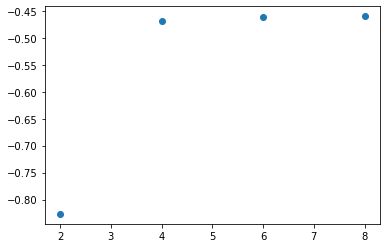

In [9]:
import numpy as np
import matplotlib.pyplot as plt

fci_energies = [-0.8266059629557765, -0.46899486453003214, -0.4605560883183338, -0.4600550476827342]
fci_energies_array = np.array(fci_energies)

e_exact = 0.25-np.log(2)
plt.scatter(np.arange(2, 10, 2), fci_energies_array, label='FCI')

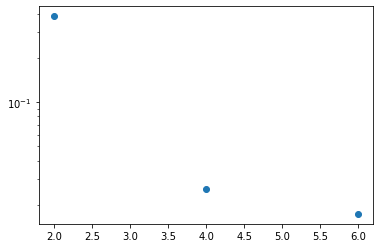

In [13]:
errors = [-0.3834587823958312, -0.025847683970086854, -0.017408907758388492]
errors_array = np.abs(np.array(errors))
plt.scatter(np.arange(2, 8, 2), errors_array, label='Error')
plt.axhline(y=0, color='r', linestyle='--')
plt.yscale('log')
plt.show()

In [84]:
def generate_inds(value, p, q, r, s):
    """
    Generate all the indices for the 4 different terms in the 2-body hamiltonian
    """
    res = []
    res.append((value, p, q, r, s))
    res.append((value, r, s, p, q))
    # res.append((-value, p, s, r, q))
    # res.append((-value, r, q, p, s))

    res.append((value, p, q, s, r))
    res.append((value, q, p, r, s))
    res.append((value, q, p, s, r))

    # permutation symmetries
    res.append((value, s, r, p, q))
    res.append((value, r, s, q, p))
    res.append((value, s, r, q, p))


    return res

for n_sites in range(2, 8, 2):

    J_xy = 1
    J_z = 1
    h = np.zeros((n_sites, n_sites))
    v = np.zeros((n_sites, n_sites, n_sites, n_sites))

    for i in range(n_sites):
        j = i+1
        if j == n_sites:
            j = 0

        h[i, i] = -J_z/2

    # populating 2body terms 
    for i in range(n_sites):
        j = i+1
        if j == n_sites:
            j = 0

        v[j, j, i, i] = J_z/4
        v[i, i, j, j] = J_z/4
        
        v[j, i, j, i] = J_xy/2
        v[i, j, i, j] = J_xy/2

        #new terms
        # v[j, i, i, j] = J_xy/2
        # v[i, j, j, i] = J_xy/2


    e_0 = J_z/4*n_sites

    # solve fullci problem
    e, fcivec = fci.direct_spin0.kernel(1*h, 1*v, n_sites, n_sites, nroots=1,
                                        max_memory=10000, pspace_size=20000)
    e_exact = 0.25-np.log(2)
    print(f"FCI energy for {n_sites}: ", (e+e_0)/(n_sites), "; error: ", (e+e_0)/(n_sites)-e_exact)

FCI energy for 2:  -0.4999999999999998 ; error:  -0.05685281944005449
FCI energy for 4:  -0.4999999999999991 ; error:  -0.056852819440053826
FCI energy for 6:  -0.46712927295533246 ; error:  -0.023982092395387178


In [85]:
from scipy.sparse import diags
# building the hamiltonian using matrices
N_sites = 6
J_ax = diags([np.ones(N_sites-1),
              np.ones(N_sites-1)], [-1, 1], format='lil')
J_ax[0, -1] = J_ax[-1, 0] = 1
J_ax = J_ax.toarray()/2 # dividing by 2 to enforce sum_q {J_pq} = J_z
mu = np.zeros(N_sites)

J_eq = J_ax.copy()


h0 = 0.25*np.sum(J_ax) - 0.5*np.sum(mu-np.diag(J_eq))
h1 = np.zeros((N_sites, N_sites))
for p in range(N_sites):
    h1[p, p] = 0.5*(mu[p]-np.sum(J_ax[p, :]))

h2 = np.zeros((N_sites, N_sites, N_sites, N_sites))
for p in range(N_sites):
    for q in range(N_sites):
        h2[p, q, p, q] = J_eq[p, q] * 2 #summing over spin. In here we don't have aaaa and bbbb parts: only aabb and bbaa
        h2[p, p, q, q] = 0.25*J_ax[p, q] * 4 # summing over spin

# solve the fullci problem
e_final, fcivec_final = fci.direct_spin0.kernel(h1,0.5*h2, N_sites, N_sites, nroots=1, max_memory=10000)
print ("FCI energy: ", (e_final+h0)/N_sites)



FCI energy:  -0.46712927295533246


In [70]:
np.sum(v-h2/2)

0.0

In [26]:
np.ones(N_sites)


array([1., 1., 1., 1., 1., 1.])